# Data Science Analyze and Present A/B Test Results

-------- company recently introduced a new bidding type, “average bidding”, as an alternative to its exisiting bidding
type, called “maximum bidding”. One of our clients, --------.com, has decided to test this new feature
and wants to conduct an A/B test to understand if average bidding brings more conversions than maximum
bidding.

In this A/B test, --------.com randomly splits its audience into two equally sized groups, e.g. the test
and the control group. A --------- company ad campaign with “maximum bidding” is served to “control group” and
another campaign with “average bidding” is served to the “test group”.

The A/B test has run for 1 month and --------.com now expects you to analyze and present the results
of this A/B test.



##### You should answer the following questions in your presentation:

1. How would you define the hypothesis of this A/B test?
2. Can we conclude statistically significant results?
3. Which statistical test did you use, and why?
4. Based on your answer to Question 2, what would be your recommendation to client?


##### Hints:
1. Your presentation should last about 15 minutes, and should be presented in English.
2. The ultimate success metric for HotelsForYou.com is Number of Purchases. Therefore, you should focus on Purchase metrics for statistical testing.
3. Explain the concept of statistical testing for a non-technical audience.
4. The customer journey for this campaign is:
    1. User sees an ad (Impression)
    2. User clicks on the website link on the ad (Website Click)
    3. User makes a search on the website (Search)
    4. User views details of a product (View Content)
    5. User adds the product to the cart (Add to Cart)
    6. User purchases the product (Purchase)
5. Use visualizations to compare test and control group metrics, such as Website Click Through Rate, Cost per Action, and Conversion Rates in addition to Purchase numbers.
6. If you see trends, anomalies or other patterns, discuss these in your presentation.
7. You can make assumptions if needed.


**Note: I translated also Turkish language**

## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skewtest
from scipy.stats import median_test
from scipy.stats import shapiro
import pylab
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import levene
from statsmodels.stats.proportion import proportions_ztest
from sklearn.impute import KNNImputer

pd.set_option("display.max_columns",None);
pd.set_option("display.max_rows",None);

## 2. Functions

In [2]:
def read_data() :
    #Maximum Bidding(Existing)
    control = pd.read_excel("AB_Case_Study.xlsx", sheet_name="Control Group")
    #Average Bidding(New)
    test = pd.read_excel("AB_Case_Study.xlsx", sheet_name="Test Group")
    
    #control dataframeinde exceldeki not kısmından gelen NaN value içeren indexler uçuruldu
    control.drop(control.index[[30,31]], inplace = True)
    
    return control, test

def get_catvar(df) :
    cat_col = [col for col in df.columns if ( (df[col].dtype == 'object') | (df[col].dtype == 'bool'))]
    kat_df = pd.DataFrame(df[cat_col], index = df[cat_col].index)
    return df, kat_df, cat_col

def get_numvar(cat_col,df):
    num_col = [c for c in df.columns if c not in cat_col]
    num_df = pd.DataFrame(df[num_col], index = df[num_col].index)
    return df, num_df, num_col

def fill_NaNValue(num_control) :
    cols = num_control.columns
    imputer = KNNImputer(n_neighbors=8)
    num_control = imputer.fit_transform(num_control)
    num_control=pd.DataFrame(num_control,columns=cols)
    return num_control

def convert_datatype(control):
    control = control.astype({'# of Impressions' : 'int64', 
                        'Reach': 'int64', 
                        '# of Website Clicks' : 'int64', 
                        '# of Searches': 'int64', 
                        '# of View Content': 'int64', 
                        '# of Add to Cart': 'int64', 
                        '# of Purchase' : 'int64'})
    return control

def outliers(control, test):
    clf= LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)
    clf.fit_predict(test.iloc[:,2:])[0:10]
    
    test_scores=clf.negative_outlier_factor_
    print("Test Score: " , np.sort(test_scores)[0:20])
    sns.boxplot(test_scores);
    
    threshold=np.sort(test_scores)[4]
    print("Threshold score: ", threshold)

    test.loc[test_scores < -1.50].index
    test.loc[test_scores == threshold]
    
    test.iloc[0,2:]=[2742.245945,79574,57168,3086,1263,1098,226,277]
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,3:5]));
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,5:6]));
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,6:]));


def feature_engineering(control, test):

    control["Website Click Through Rate"] = control["# of Website Clicks"] / control["# of Impressions"] * 100
    test["Website Click Through Rate"] = test["# of Website Clicks"] / test["# of Impressions"] * 100

    control["Number of Action"] = control["# of Impressions"] + control["# of Website Clicks"] + control["# of Searches"] + control["# of View Content"] + control["# of Add to Cart"] + control["# of Purchase"]
    test["Number of Action"] = test["# of Impressions"] + test["# of Website Clicks"] + test["# of Searches"] + test["# of View Content"] + test["# of Add to Cart"] + test["# of Purchase"]

    control["Cost per Action"] = control["Spend [USD]"] / control["Number of Action"]
    test["Cost per Action"] = test["Spend [USD]"] / test["Number of Action"]

    control["Conversion Rate"] = control["Number of Action"] / control["# of Website Clicks"] * 100
    test["Conversion Rate"] = test["Number of Action"] / test["# of Website Clicks"] * 100
    
    return control, test

def data_prepare_for_visualization(control,test):
    control_nop = pd.DataFrame(control["# of Purchase"])
    test_nop = pd.DataFrame(test["# of Purchase"])

    control_wctr= pd.DataFrame(control["Website Click Through Rate"])
    test_wctr= pd.DataFrame(test["Website Click Through Rate"]) 

    control_cpa= pd.DataFrame(control["Cost per Action"]) 
    test_cpa= pd.DataFrame(test["Cost per Action"])

    control_cr= pd.DataFrame(control["Conversion Rate"])
    test_cr= pd.DataFrame(test["Conversion Rate"])
    
    Group_A = pd.concat([control_nop, control_wctr, control_cpa, control_cr], axis = 1)
    Group_A["Group"] = "A (MaximumBidding)"

    Group_B = pd.concat([test_nop, test_wctr, test_cpa, test_cr], axis = 1)
    Group_B["Group"] = "B (AverageBidding)"

    #Tum veri
    AB = pd.concat([Group_A, Group_B])
    AB
    return AB, control_nop, test_nop

def data_prepare_for_hypothesis_testing(control_nop, test_nop):
    controlB = pd.concat([control_nop, test_nop], axis = 1)
    controlB.columns = ["A","B"]
    return controlB
    
def num_boxplot(fig, axarr, boyut, cols, hue):
    for i in boyut :
        for j in boyut :
            for c in cols :
                sns.boxplot(y=c, x = hue, hue = hue, data = AB, ax=axarr[i][j])
                cols.remove(c)
                break
                    
def show_boxplot(nrows, ncols, boyut, cols, figsize):
    fig, axarr = plt.subplots(nrows, ncols, figsize=figsize)
    num_boxplot(fig, axarr, boyut, cols, "Group")
    

def checkReject(p_value, alpha = 0.05):
    if p_value < alpha :
        print(f'{p_value} < alpha(0.05) so >>> H0 REJECTED <<< (H0 hipotezi REDEDILDI)')
   
    elif p_value > alpha :
        print(f'{p_value} > alpha(0.05) so >>> H0 CAN\'T BE REJECTED <<< (H0 hipotezi REDEDILEMEDI)')

## 3. Data Preparation

In [3]:
control, test = read_data()

In [4]:
control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,2017.01.01,2436.124529,90572.0,75440.0,4150.0,1657.0,1541.0,566.0,383.0
1,Control Campaign,2017.01.02,2621.043006,129612.0,95667.0,6387.0,2265.0,1563.0,1577.0,644.0
2,Control Campaign,2017.01.03,2427.021083,132803.0,121762.0,6887.0,3100.0,2048.0,1381.0,639.0
3,Control Campaign,2017.01.04,2565.414978,120570.0,104011.0,6478.0,2579.0,2083.0,1650.0,649.0
4,Control Campaign,2017.01.05,2648.683326,95822.0,69059.0,4532.0,1823.0,1220.0,940.0,455.0


In [5]:
test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,2017.01.01,2335.586267,160244,121551,8223,2989,2949,1371,913
1,Test Campaign,2017.01.02,2899.490621,100793,68241,4972,2162,1388,1253,510
2,Test Campaign,2017.01.03,3031.740149,89525,83450,3514,1365,1251,995,391
3,Test Campaign,2017.01.04,2794.847648,110122,89985,4411,1533,1134,951,434
4,Test Campaign,2017.01.05,2201.845423,122204,84000,5165,1582,1007,810,492


In [6]:
control.isnull().sum()

Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       1
Reach                  1
# of Website Clicks    1
# of Searches          1
# of View Content      1
# of Add to Cart       1
# of Purchase          1
dtype: int64

In [7]:
control.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 10 columns):
Campaign Name          30 non-null object
Date                   30 non-null object
Spend [USD]            30 non-null float64
# of Impressions       29 non-null float64
Reach                  29 non-null float64
# of Website Clicks    29 non-null float64
# of Searches          29 non-null float64
# of View Content      29 non-null float64
# of Add to Cart       29 non-null float64
# of Purchase          29 non-null float64
dtypes: float64(8), object(2)
memory usage: 2.6+ KB


In [8]:
#Kategorik Değişkenler
df, kat_control, cat_col_A = get_catvar(control)

#Numerik Değişkenler
df, num_control, num_col_A = get_numvar(cat_col_A, df)

In [9]:
kat_control.head()

,Campaign Name,Date
0,Control Campaign,2017.01.01
1,Control Campaign,2017.01.02
2,Control Campaign,2017.01.03
3,Control Campaign,2017.01.04
4,Control Campaign,2017.01.05


If we look at the 12th line, we can see the NaN value.

In [10]:
# bakarsak 12. satirda NaN value gorebiliriz

num_control.head(15)

,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,2436.124529,90572.0,75440.0,4150.0,1657.0,1541.0,566.0,383.0
1,2621.043006,129612.0,95667.0,6387.0,2265.0,1563.0,1577.0,644.0
2,2427.021083,132803.0,121762.0,6887.0,3100.0,2048.0,1381.0,639.0
3,2565.414978,120570.0,104011.0,6478.0,2579.0,2083.0,1650.0,649.0
4,2648.683326,95822.0,69059.0,4532.0,1823.0,1220.0,940.0,455.0
5,2306.081623,118268.0,83562.0,6596.0,2955.0,1815.0,1455.0,734.0
6,2356.996404,144806.0,105315.0,8139.0,3262.0,2559.0,1502.0,799.0
7,2670.222971,97719.0,74746.0,5508.0,2282.0,1840.0,837.0,605.0
8,2720.901584,113781.0,97334.0,5901.0,2109.0,1955.0,1959.0,562.0
9,2441.534142,125097.0,90192.0,7646.0,2914.0,2200.0,1433.0,717.0


Fill the control dataframe values NaN value with KNNImputer.

In [11]:
# control dataframe degerleri NaN value yu KNNImputer ile dolduralım

num_control = fill_NaNValue(num_control)
num_control.head()

,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,2436.124529,90572.0,75440.0,4150.0,1657.0,1541.0,566.0,383.0
1,2621.043006,129612.0,95667.0,6387.0,2265.0,1563.0,1577.0,644.0
2,2427.021083,132803.0,121762.0,6887.0,3100.0,2048.0,1381.0,639.0
3,2565.414978,120570.0,104011.0,6478.0,2579.0,2083.0,1650.0,649.0
4,2648.683326,95822.0,69059.0,4532.0,1823.0,1220.0,940.0,455.0


Let's combine categorical and numerical variables with the concept.

In [12]:
# kategorik ve numerik degiskenleri concat ile birlestirelim.

control = pd.concat([kat_control,num_control], axis = 1)
control.head(3)

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,2017.01.01,2436.124529,90572.0,75440.0,4150.0,1657.0,1541.0,566.0,383.0
1,Control Campaign,2017.01.02,2621.043006,129612.0,95667.0,6387.0,2265.0,1563.0,1577.0,644.0
2,Control Campaign,2017.01.03,2427.021083,132803.0,121762.0,6887.0,3100.0,2048.0,1381.0,639.0


Let's do a data type conversion.

In [13]:
# Veri Tipi Dönüşümleri

control = convert_datatype(control)

# boyut kontrolu yani degisken sayilarina bakalim
print(control.shape)
print(test.shape)

(30, 10)
(30, 10)


In [14]:
# info kontrolu yapalim

print(control.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 10 columns):
Campaign Name          30 non-null object
Date                   30 non-null object
Spend [USD]            30 non-null float64
# of Impressions       30 non-null int64
Reach                  30 non-null int64
# of Website Clicks    30 non-null int64
# of Searches          30 non-null int64
# of View Content      30 non-null int64
# of Add to Cart       30 non-null int64
# of Purchase          30 non-null int64
dtypes: float64(1), int64(7), object(2)
memory usage: 2.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
Campaign Name          30 non-null object
Date                   30 non-null object
Spend [USD]            30 non-null float64
# of Impressions       30 non-null int64
Reach                  30 non-null int64
# of Website Clicks    30 non-null int64
# of Searches          30 non-null int64
# of View Content     

## 4. Preparing Data for Hypothesis Testing (A/B Test)

Let's create a feature with the help of functions and create a feature for visualization and prepare it.

In [15]:
# fonk yardimiyla feature uretelim
control, test = feature_engineering(control, test)


# fonk yardimiyla gorsellestirme icin feature uretip hazirlik
AB, control_nop, test_nop = data_prepare_for_visualization(control, test)
AB.head(3)

,# of Purchase,Website Click Through Rate,Cost per Action,Conversion Rate,Group
0,383,4.581990,0.024640,2382.385542,A (MaximumBidding)
1,644,4.927784,0.018452,2224.017536,A (MaximumBidding)
2,639,5.185877,0.016526,2132.394366,A (MaximumBidding)


Let's look at the numbers A and B.

In [16]:
# A ve B sayilarina bakalim

AB["Group"].value_counts()

A (MaximumBidding)    30
B (AverageBidding)    30
Name: Group, dtype: int64

### 4.1. Website Click Through Rate (CTR)
- It is a rate that shows how often the users who saw the ad CLICK the ad.
- Number of Ad Clicks / Number of Ad Displays
- Example: 5 clicks, CTR at 100 impressions = 5%

- ##### Use visualizations to compare test and control group metrics, such as Website Click Through Rate, Cost per Action, and Conversion Rates in addition to Purchase numbers.

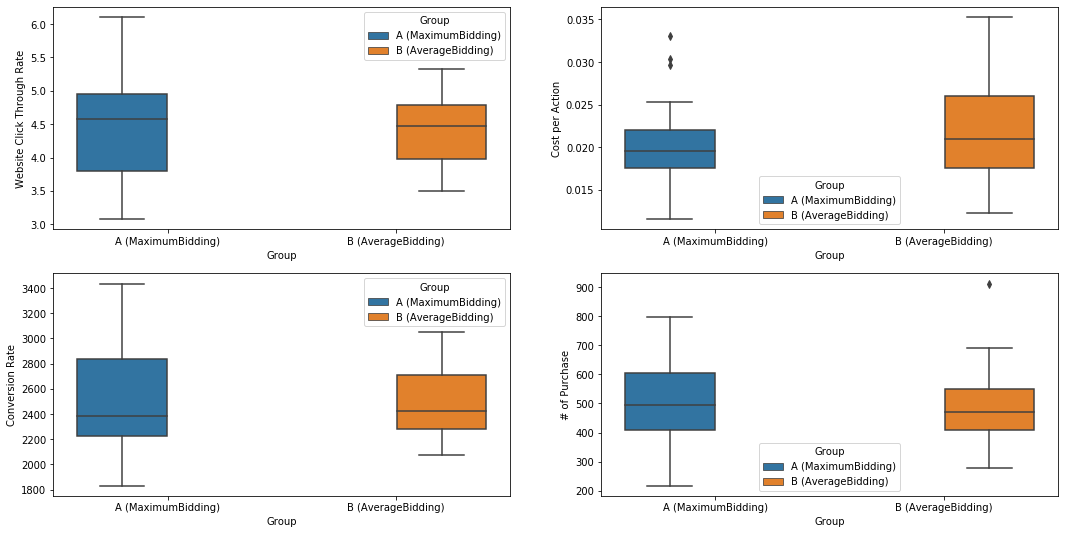

In [17]:
# - Reklamı GÖREN kullanıcıların, reklamı ne sıklıkta TIKLADIKLARINI gösteren bir orandır.
# - Reklam Tıklanma Sayısı/ Reklam Gösterilem Sayısı
# - Örnek: 5 tıklama, 100 gösterimde CTR= %5

cols = ["Website Click Through Rate","Cost per Action","Conversion Rate","# of Purchase"]
show_boxplot(2,2,[0,1],cols,(18,9))

Let's create our df for AB test.

In [18]:
# AB testi icin df mizi olusturduk

df_AB = data_prepare_for_hypothesis_testing(control_nop, test_nop)
df_AB.head(3)

,A,B
0,383,913
1,644,510
2,639,391


## 5. Two Independent Sample T Test (Bağımsız İki Örneklem T Testi (A/B Testi))
### 5.1. Assumption Check (Varsayim Kontrolu)
#### 5.1.1. Normality Assumption (**Shapiro Test**) ~ (Normallik Varsayimi)

 * **H0**: Normal distribution assumption is provided.
 * **H1**: ... not provided.

In [19]:
# H0 : Normal dağılım varsayımı sağlanmaktadır.
# H1 : ... sağlanmamaktadır.

# A kismi icin kontrol
shapiro(df_AB.A)

(0.9881329536437988, 0.9781011939048767)

In [20]:
p_value = round(shapiro(df_AB.A)[1], 3)
checkReject(p_value)

0.978 > alpha(0.05) so >>> H0 CAN'T BE REJECTED <<< (H0 hipotezi REDEDILEMEDI)


**Comment**: H0 hypothesis could not be rejected because pvalue = 0.978> 0.05.
Statistically, **it could not be rejected that the normal distribution assumption** of the data set in which the Maximum Bidding (Control Group) was measured was met.



(**Yorum** : pvalue = 0.978 > 0.05 olduğu için H0 hipotezi reddedilemedi.
İstatistiksel olarak, Maximum Bidding'in (Kontrol Group) ölçüldüğü veri setinin **normal dağılım varsayımının sağlandığı reddedilemedi.**)

In [21]:
# B kismi icin kontrol
shapiro(df_AB.B)

(0.9188652038574219, 0.02506561577320099)

In [22]:
p_value = round(shapiro(df_AB.B)[1], 3)
checkReject(p_value)

0.025 < alpha(0.05) so >>> H0 REJECTED <<< (H0 hipotezi REDEDILDI)


**Comment**: H0 hyptothesis was rejected because pvalue = 0.025 <0.05.
Statistically, **it could be rejected that the normal distribution assumption** of the data set in which the Maximum Bidding (Control Group) was measured was met.


(**Yorum**: pvalue = 0.025 < 0.05 olduğu için H0 hiptotezi reddedildi.
İstatistiksel olarak, Average Bidding'in (Test Group) ölçüldüğü veri setinin **normal dağılım varsayımının sağlandığı reddedildi.**)

### 5.1.2. Variance Homogeneity Assumption (**Levene Testi**) ~ (Varyans Homojenliği Varsayımı)
 * **H0** : Variances are homogeneous.
 * **H1** : Variances are not homogeneous.

In [23]:
# **H0** : Varyanslar homojendir.
# **H1** : Varyanslar homojen değildir.

stats.levene(df_AB.A, df_AB.B)

LeveneResult(statistic=1.4381249270961438, pvalue=0.2353194009233704)

In [24]:
p_value = round(stats.levene(df_AB.A, df_AB.B)[1], 3)
checkReject(p_value)

0.235 > alpha(0.05) so >>> H0 CAN'T BE REJECTED <<< (H0 hipotezi REDEDILEMEDI)


**Comment:** Since the pvalue = 0.235> 0.05, the H0 hypothesis, that is, **the variances were not statistically rejected as homogeneous.**

(**Yorum:** pvalue = 0.235 > 0.05 olduğu için H0 hipotezi yani **varyansların homojen olduğu istatistiksel olarak reddedilemedi.**)

### 5.1.3. Nonparametric Independent Two-Sample T Test (**Mannwihtneyu**) ~ (Nonparametrik Bağımsız İki Örneklem T Testi)

- Since the normality of the distribution of the data set in which Average Bidding (Test Group) was measured was rejected, the NonParametric Independent Two-Sample T Test was applied for the Hypothesis Test.

**Hypothesis:**

 * **H0** : When it comes to Maximum Bidding and Average Bidding, there is no statistically significant difference between the purchasing amounts of the two groups. ($\mu_1 = \mu_2$)

 * **H1** : ... there is a difference ($\mu_1 \neq \mu_2$)

In [25]:
# Average Biddingin (Test Group) ölçüldüğü veri setinin dağılımının normalliği reddedildiğinden, Hipotez Testi için NonParametrik Bağımsız İki Örneklem T Testi uygulanmıştır.

# Hipotez : 
# **H0**: Maximum Bidding ile Average Bidding söz konusu olduğunda iki grubun satın alma miktarları arasında istatistiksel olarak anlamlı fark yoktur. (m1 = m2)

# **H1**: ... fark vardır (M1 != M2)

stats.mannwhitneyu(df_AB["A"], df_AB["B"])

MannwhitneyuResult(statistic=391.0, pvalue=0.19352350307853528)

In [26]:
p_value = round(stats.mannwhitneyu(df_AB["A"], df_AB["B"])[1], 3)
checkReject(p_value)

0.194 > alpha(0.05) so >>> H0 CAN'T BE REJECTED <<< (H0 hipotezi REDEDILEMEDI)


**Comment: ** The H0 hypothesis **could not be rejected** because the result of the Nonparametric Two Independent Samples T Test was pvalue = 0.19 > 0.05.

So, we could not reject that there was no statistically significant difference between the purchase amounts of the Average Bidding and Maximum Bidding systems.



(**Yorum :** Nonparametrik Bağımsız İki Örneklerm T Testi sonucu pvalue = 0.19 > 0.05 olduğu için H0 hipotezi **reddedilemedi.** 
Yani, Average Bidding ve Maximum Bidding sistemlerinin satın alma miktarları arasında istatistiksel olarak anlamlı fark olmadığını reddedemedik.)

## 6. Conclusion and Evaluation 


##### You should answer the following questions in your presentation:


**1. How would you define the hypothesis of this A/B test ?**

   **Hipotez:**
   - **H0** : When it comes to Maximum Bidding and Average Bidding, there is no statistically significant difference between the purchase amounts of the two groups. 
    - (Maximum Bidding ile Average Bidding söz konusu olduğunda iki grubun satın alma miktarları arasında istatistiksel olarak anlamlı fark yoktur.)
    
   - **H1** : ... there is a difference (fark vardır)

   
**2. Can we conclude statistically significant results?**

   - I observed that there was no statistically significant difference between the amount of purchases made with the Maximum Bidding and Average Bidding methods, since the pvalue value for the ** Nonparametric Independent Two-Sample T Test ** I performed using the Test and Control group data set was greater than 0.05. 
    - (Test ve Kontrol grubu veri setini kullanarak gerçekleştirmiş olduğum **Nonparametrik Bağımsız İki Örneklem T Testi** için pvalue değeri 0.05'ten büyük olduğundan, Maximum Bidding ve Average Bidding metodları ile yapılan satın alma miktarları arasında istatistiksel olarak anlamlı bir fark çıkmadığını gözlemledim.)


**3. Which statistical test did you use, and why?**
    
   - I used the nonparametric Independent Two Sample T Test (Mannwihtneyu) statistical method. Because the return of a new system is wanted to be tested. For this purpose, user behaviors are examined and statistically compared with each other with the Control Group, which uses the old system with equal number of observations, and the Test Group, which uses the new system. Since these 2 groups will use different systems independently of each other, Independent Two-Sample T Test was used.
    - (Nonparametrik Bağımsız İki Örneklem T Testi (Mannwihtneyu) istatistiksel metodunu kullandım. Çünkü, yeni bir sistemin getirisi test edilmek isteniyor. Bunun için eşit gözlem sayılarını içeren eski sistemi kullanan Kontrol Grubu ve yeni sistemi kullanan Test Grubu ile kullanıcı davranışları inceleniyor ve birbirleri ile istatistiksel olarak kıyaslanıyor. Bu 2 Group birbirinden bağımsız farklı sistemleri kullanacağı için, Bağımsız İki Örneklem T Testi kullanıldı.)
   
    
**4. Based on your answer to Question 2, what would be your recommendation to client?**

   - This test was conducted on datasets containing 30 observations. In accordance with the Law of Large Numbers, as the number of observations increases, the tests performed will produce the most realistic results. Therefore, since there is no statistically significant difference between the returns of the old and new systems, it would be better to examine the systems for a while by increasing the number of observations in the data set. In other words, repeating this hypothesis test with new data sets by increasing the amount of purchases in both systems and continuing to collect data can give us a statistically significant difference and this situation should be tested.
    - (Bu test 30 ar gözlem içeren veri setleri üzerinde yapılmıştır. Büyük Sayılar Yasası gereği, gözlem sayısı çoğaldıkça, yapılan testler gerçeğe en yakın sonuçları üretecektir. Bu nedenle eski ve yeni sistemlerin getirileri arasında istatistiksel olarak anlamlı bir fark çıkmadığı için, veri setindeki gözlem sayısını artırarak sistemleri bir süre daha incelemek iyi olacaktır. Yani, her iki sistemdeki satın alma miktarlarının artması sağlanarak ve veri toplamaya devam edilerek, yeni veri setleri ile bu hipotez testinin tekrarlanması, bize istatistiksel olarak anlamlı fark çıkartabilir ve bu durum denenmelidir.)



## HINTS
**Explain the concept of statistical testing for a non-technical audience.**
  
  - When we develop a system technically by investing time and resources, we want to measure whether the new system is a better system than the old one, whether the work we do is worth the result we have, in short, whether the stone we throw is worth the frog we frightened. It is possible to talk about this situation with numbers, net values and statistics. For example, here we divide our data into 2 equal parts. We measured the performance of the old system with the first of these parts and the performance of the new system with the second, and these measurements produced some mathematical values for us. By comparing these values with some statistical assumptions (such as comparing the pvalue value with 0.05), we were able to determine whether there was a statistical difference between the performance of these systems and performed a statistical test.
   - (Zaman ve kaynak yatırımı yaparak teknik olarak bir sistem geliştirdiğimizde, yeni sistemin eskisine oranla daha iyi bir sistem olup olmadığını, yaptığımız işin aldığımız sonuca deyip değmediğini, kısacası attığımız taşın ürküttüğümüz kurbağaya değip değmediğini ölçmek isteriz. Bu durumu sayılarla, net değerlerle, istatistiki olarak konuşabilmemiz mümkündür. Örneğin burada, elimizdeki verileri 2 eşit parçaya böldük. Bu parçalardan ilki ile eski sistemin performansını, ikincisi ile yeni sistemin performansını ölçtük ve bu ölçümler bize matematiksel bazı değerler üretti. İstatistiki bazı varsayımlar ile (örneğin pvalue değerini 0.05 ile kıyaslamak gibi) bu değerleri kıyaslayarak, bu sistemlerin performansı arasında istatistiki olarak bir fark olup olmadığını belirleyebildik ve istatistiki bir test gerçekleştirmiş olduk.)



**Use visualizations to compare test and control group metrics, such as Website Click Through Rate, Cost per Action, and Conversion Rates in addition to Purchase numbers.**

  - For the newly derived "Website Click Through Rate", "Cost per Action", "Conversion Rates" variables and the "Purchase numbers" variable we have, the above visualization charts in Test and Control groups are below.
   - (Yeni türetilmiş olan "Website Click Through Rate", "Cost per Action", "Conversion Rates" değişkenleri ve elimizde olan "Purchase numbers" değişkeni için, Test ve Kontrol Grouplarında yukarıda almış olduğu görselleştirme grafikleri aşağıdadır.)
  
  
 
## 7. Recommendation to Client

- When the new system is compared with the old system, it is seen that the number of purchases does not change, the cost increases and the clicks decrease.
 - (Yeni sistem ile eski sistem karşılaştırıldığında, satın alma sayısının değişmediği, maliyetin arttığı ve tıklamanın düştüğü görülmektedir.)
 
- When the Conversion Rate is based on the purchasing status among those who add to the basket and those who look at the product details, a comparison is made in favor of the test group.
 - (Conversion Rate, sepete ekleyenler ve ürün detayına bakanlar arasından satın alma durumuna göre baz alınıp karşılaştırma yapıldığında test grubu lehine sonuç alınmıştır.)
 
- **Therefore, retesting is recommended by collecting more data. If there is no such opportunity or time, it is recommended to continue with the existing bidding system.**
 - **(Bu nedenle daha fazla veri toplayarak tekrar test yapılması önerilmektedir. Böyle bir imkan ya da vakit yoksa mevcut bidding sistemi ile devam etmesi önerilir.)**

![image.png](image.png)